<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Прочтение-данных" data-toc-modified-id="Прочтение-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Прочтение данных</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Предобработка данных</a></span></li><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Вывод:</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Тренд" data-toc-modified-id="Тренд-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Тренд</a></span></li><li><span><a href="#Сезонность" data-toc-modified-id="Сезонность-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Сезонность</a></span></li><li><span><a href="#Проверка-на-стационарность" data-toc-modified-id="Проверка-на-стационарность-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Проверка на стационарность</a></span></li><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Вывод:</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Подготовка-признаков" data-toc-modified-id="Подготовка-признаков-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Подготовка признаков</a></span></li><li><span><a href="#Разделение-выборок" data-toc-modified-id="Разделение-выборок-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Разделение выборок</a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>LGBMRegressor</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>LGBMRegressor</a></span></li></ul></li><li><span><a href="#Общий-вывод:" data-toc-modified-id="Общий-вывод:-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод:</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

*План действий*:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

## Подготовка

Для начала импортируем все нужные для работы библиотеки и функции.

In [1]:
!pip install -U scikit-learn
!pip3 install catboost
!pip install lightgbm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, make_scorer

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit

from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

sns.set_style('darkgrid')

Requirement already up-to-date: scikit-learn in c:\users\user\anaconda3\lib\site-packages (1.0.1)


### Прочтение данных

Взглянем на данные и общую информацию о них.

In [2]:
df = pd.read_csv('taxi.csv', parse_dates=[0])

df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
...,...,...
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39


Данные представляют собой таблицу из двух колонок. Каждая строка несет информацию о количество заказов такси в определенное время. Временной диапазон данных - от марта 2018 до сентября 2018. Временной промежуток между объектами 10 минут. 

- datetime - время 
- num_orders - количество заказов

Сразу можно заметить, что отсутствующих значений нет.

### Предобработка данных

Стоит проверить не повторяется одно и то же время.

In [3]:
df.duplicated('datetime').sum()

0

Дубликатов времени нет.

Для удобства дальнейшей работы сделаем колонку с датами индексами.

In [4]:
df.set_index('datetime', inplace=True)

Для работы с временными рядами важен порядок течения времени. Проверим его.

In [5]:
df.index.is_monotonic

True

10 минут довольно коротки промежуток времени. Ресемплируем данные по одному часу.

In [6]:
df = df.resample('1H').sum()

### Вывод:

Данные были успешно загружены и прочитаны.

Результаты предобработки:
- пропусков и дубликатов нет;
- дубликатов нет;
- временной ряд монотонен;
- временной ряд ресемплирован на удобный промежуток вермени.

## Анализ

Рассмотрим два важных показателя временных рядов: *тренд* и *сезонность*.

### Тренд

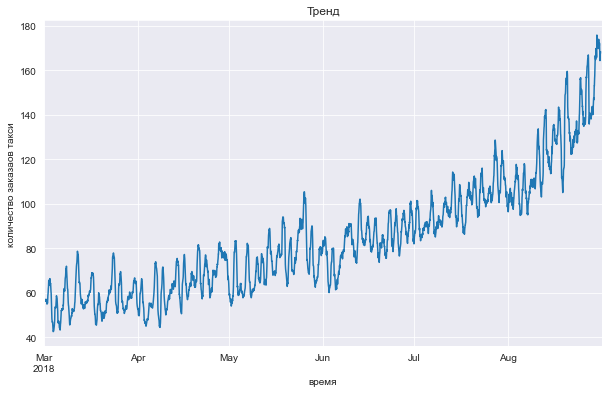

In [7]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(10, 6))
decomposed.trend.plot()
plt.title('Тренд')
plt.xlabel('время')
plt.ylabel('количество заказаов такси')
plt.show()

Здесь явно видно что люди все чаще пользуются такси.

### Сезонность

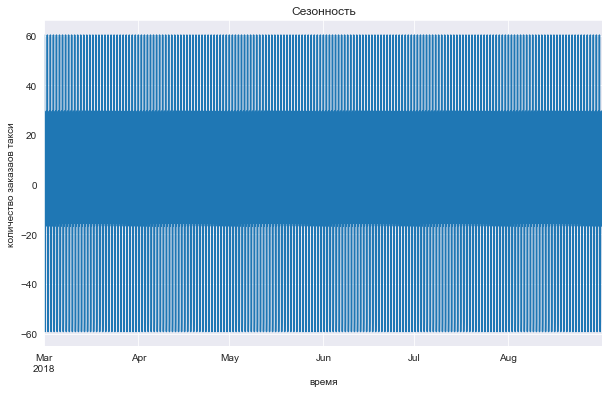

In [8]:
plt.figure(figsize=(10, 6))
decomposed.seasonal.plot()
plt.title('Сезонность')
plt.xlabel('время')
plt.ylabel('количество заказаов такси')
plt.show()

Тут из графика ничего не понять. Рассмотрим сезонность в трех приближениях: за месяц, неделю и день.

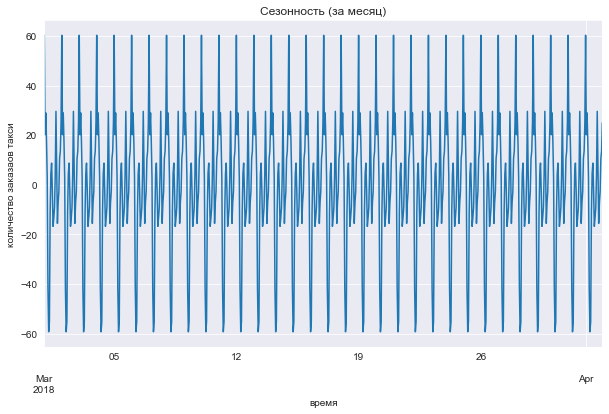

In [9]:
plt.figure(figsize=(10, 6))
decomposed.seasonal['2018-03-01':'2018-04-01'].plot()
plt.title('Сезонность (за месяц)')
plt.xlabel('время')
plt.ylabel('количество заказаов такси')
plt.show()

Здесь уже заметна сезонность, но пока все равно не ясно какой промежуток вермени она составляет.

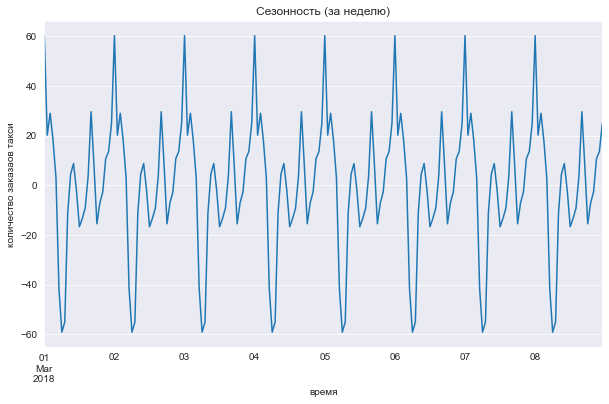

In [10]:
plt.figure(figsize=(10, 6))
decomposed.seasonal['2018-03-01':'2018-03-08'].plot()
plt.title('Сезонность (за неделю)')
plt.xlabel('время')
plt.ylabel('количество заказаов такси')
plt.show()

Здесь уже явно видно, что сезонность составляет одни сутки, рассмотрим поближе дней промежуток.

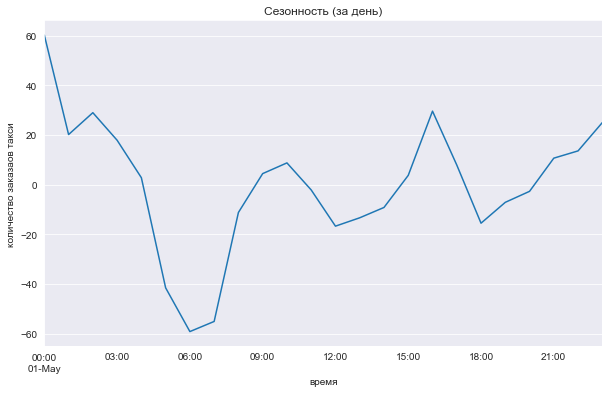

In [11]:
plt.figure(figsize=(10, 6))
decomposed.seasonal['2018-05-01'].plot()
plt.title('Сезонность (за день)')
plt.xlabel('время')
plt.ylabel('количество заказаов такси')
plt.show()

Наименьший спрос возникает в 5-7 утра, все люди спят. Пики приходятся на моменты когда люди едут на работу (в райное 10 часов), когда заканчивают рабочий день (пять вечера) и затем самый большой пик к полуночи - здесь скорее всего объясняется позним временем, когда перестает работать общественный транспорт и люди вынужденны вызывать такси, а так же теми, кто в этот вечер отдыхает.

### Проверка на стационарность

Смотря на тренд и сезонность, кажется, что ряд нестационарен. Сделаем проверку с помощью обобщенного теста Дикки-Фуллера.

In [12]:
test = adfuller(df['num_orders'])
print('adf:', test[0])
print('p-value:', test[1])
print('Critical values:', test[4])
if test[0]> test[4]['5%']: 
    print('Есть единичные корни, ряд не стационарен')
else:
    print('Единичных корней нет, ряд стационарен')

adf: -3.0689242890279274
p-value: 0.028940051402615206
Critical values: {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}
Единичных корней нет, ряд стационарен


### Вывод:

В ходе анализа было выявленно:
- график тренда показал, что заказы такси увеличиваются со временем
- сезонность составляет одни сутки
- тест Дикки-Фуллера показал, что ряд стационарен

## Обучение

Будем тестировать 3 алгоритма:

1. RandomForestRegressor
2. CatBoostRegressor
3. LightGBMRegressor

Для всех алгоритмов найдем лучшие гиперпараметры с помощью кросс-валидации. 

In [13]:
# не рабоет neg_root_mean_squared_error, поэтому для скореров внутри гридсерча сделал свой рмсе
def make_rmse(target, predict):
    return mean_squared_error(target, predict) ** 0.5
    
rmse = make_scorer(make_rmse, greater_is_better=False)

### Подготовка признаков

Так как в исходных данных у нас только целевой признак, то создадим другипе рпизнаки для обучения. Добавим данные о дате: какой это месяц, день месяца и день недели. Также добавим отстающие значения, они  подскажут, будет ли прогноз расти или уменьшаться.

In [14]:
def make_features(data, max_lag, rolling_mean_size):
    
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()


make_features(df, 96, 15)

### Разделение выборок

Теперь разделим на обучающую и тестовую выборки. 

In [15]:
train_X, test_X, train_Y, test_Y = train_test_split(df.drop('num_orders', axis=1), df['num_orders'],
                                                    test_size=0.1, shuffle=False)

Из-за добавления новых лагов у нас появились пропуски в тренировочных данных. Так как их меньше 5% мы можем их отбросить, чтобы обучать модели, котороые не могу работать с пропущенными значениями.

In [16]:
train_X.dropna(inplace=True)

train_Y = train_Y[train_Y.index.isin(train_X.index)]

### RandomForestRegressor

In [17]:
%%time

model_forest = RandomForestRegressor(random_state=5)

params_forest = {'n_estimators':np.arange(5, 30, 8), 'max_depth': [None, 3, 5, 8]}
grid_forest = GridSearchCV(model_forest, params_forest, cv=TimeSeriesSplit(n_splits=8).split(train_X), n_jobs=-1, scoring=rmse)
grid_forest.fit(train_X, train_Y)

print('Лушие параметры для RandomForest:', grid_forest.best_params_, end='\n\n')

Лушие параметры для RandomForest: {'max_depth': None, 'n_estimators': 29}

Wall time: 22 s


### CatBoostRegressor

In [18]:
%%time

model_cat = CatBoostRegressor(loss_function='RMSE', iterations=150, random_seed=5, verbose=False)
parameters_cat = {'depth':[5,10], 'learning_rate':np.arange(0.1,1,0.2)}
cat_grid = GridSearchCV(model_cat, parameters_cat, cv=TimeSeriesSplit(n_splits=8).split(train_X), n_jobs=-1)

cat_grid.fit(train_X, train_Y)

print('Лучшие параметры для CatBoost:', cat_grid.best_params_, end='\n\n')

Лучшие параметры для CatBoost: {'depth': 5, 'learning_rate': 0.1}

Wall time: 11min 55s


### LGBMRegressor

In [19]:
%%time

model_lgbm = LGBMRegressor(metric='rmse') 

params_lgbm = {'num_leaves':[31, 100, 200], 'learning_rate':np.arange(0.1,1,0.2)}
grid_lgbm = GridSearchCV(model_lgbm, params_lgbm, cv=TimeSeriesSplit(n_splits=8).split(train_X), n_jobs=-1)

grid_lgbm.fit(train_X, train_Y)

print('Лучшие параметры для LightGBM:', grid_lgbm.best_params_, end='\n\n')

Лучшие параметры для LightGBM: {'learning_rate': 0.1, 'num_leaves': 200}

Wall time: 42.9 s


## Тестирование

Осталось лишь протестировать наши модели на тестовых данных.

In [20]:
# функция отрисовывает график предсказаний вместе с реальными значениями
def make_plot(test, preds):
    df = pd.DataFrame(test)
    df['preds'] = preds
    fig = plt.figure(figsize=(20, 8))
    ax = fig.gca()
    df.plot(ax=ax)
    plt.xlabel('дата')
    plt.ylabel('количество заказов')
    plt.show()

### RandomForestRegressor

RMSE на тестовой выборке модели RandomForestRegressor: 40.77258570745795


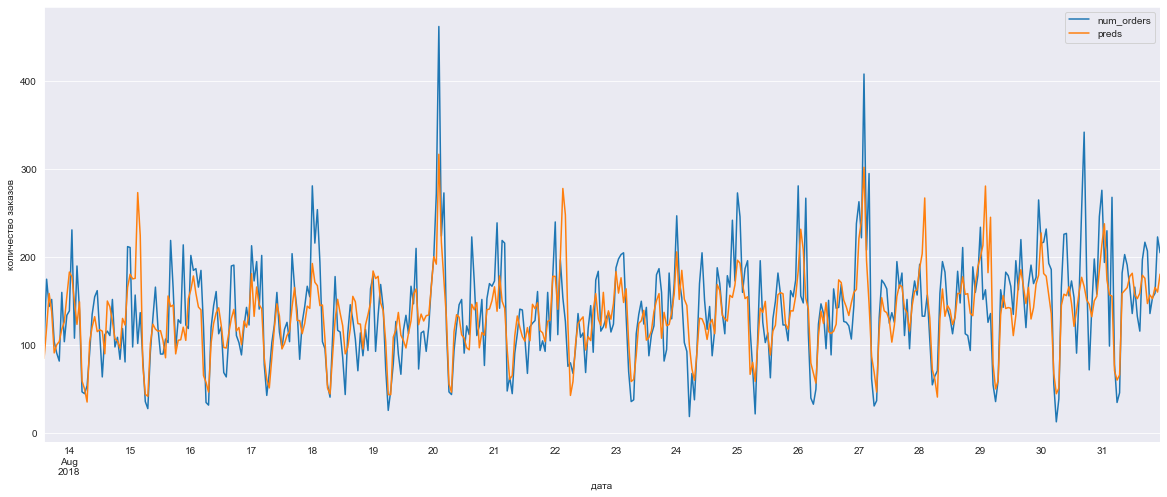

In [21]:
model_forest_test = RandomForestRegressor(random_state=5, n_estimators=29, max_depth=None)
model_forest_test.fit(train_X, train_Y)

forest_preds = model_forest_test.predict(test_X)

forest_rmse_test = mean_squared_error(test_Y, forest_preds) ** 0.5

print('RMSE на тестовой выборке модели RandomForestRegressor:', forest_rmse_test)
make_plot(test_Y, forest_preds)

### CatBoostRegressor

RMSE на тестовой выборке модели CatBoostRegressor: 38.151589418899796


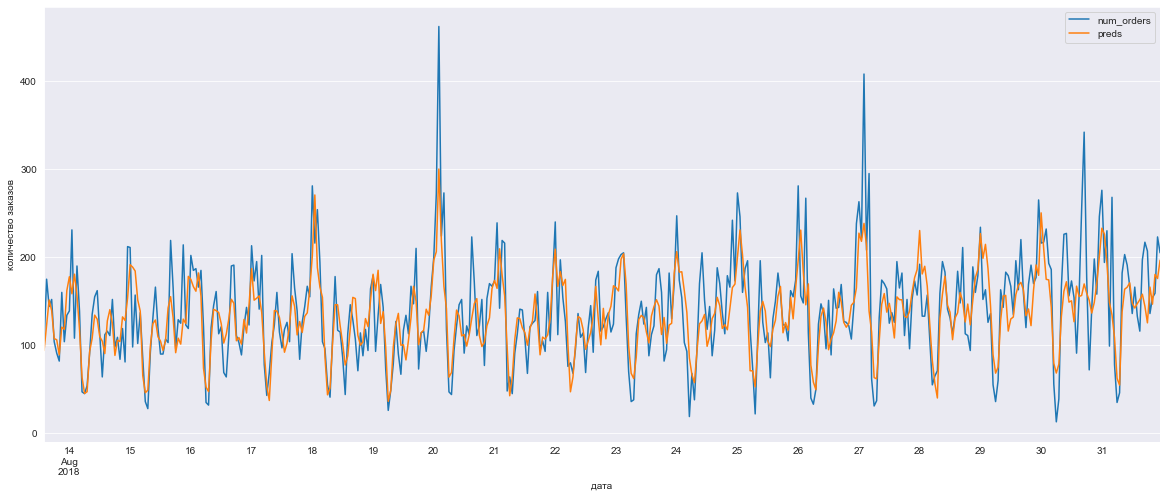

In [22]:
model_cat_test = CatBoostRegressor(loss_function='RMSE', iterations=150, random_seed=5, verbose=False,
                                  learning_rate=0.1, depth=5)
model_cat_test.fit(train_X, train_Y)

cat_preds = model_cat_test.predict(test_X)

cat_rmse_test = mean_squared_error(test_Y, cat_preds) ** 0.5

print('RMSE на тестовой выборке модели CatBoostRegressor:', cat_rmse_test)
make_plot(test_Y, cat_preds)

### LGBMRegressor

RMSE на тестовой выборке модели LGBMRegressor: 39.18454315947607


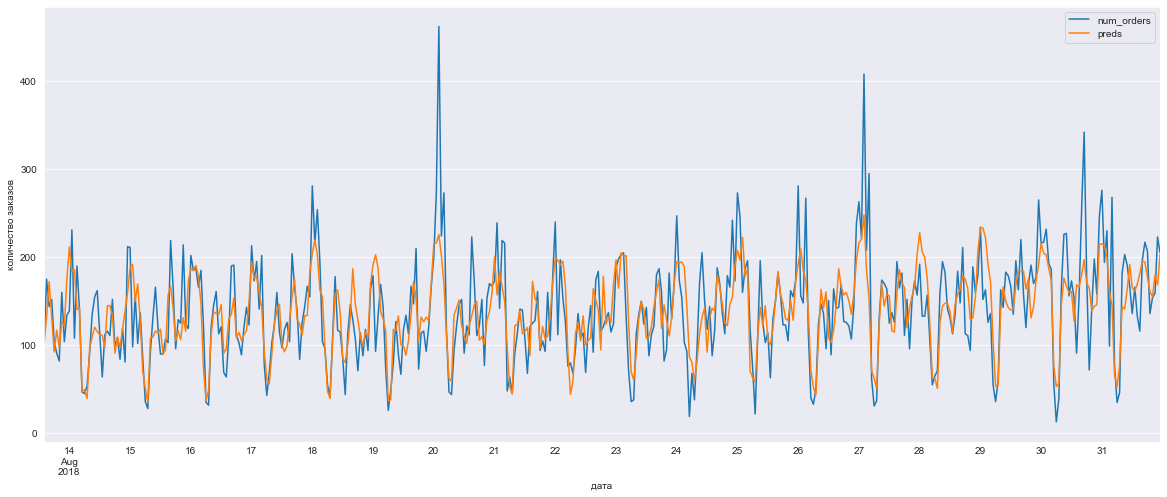

In [23]:
model_lgbm_test = LGBMRegressor(metric='rmse', learning_rate=0.1 , num_leaves=200)
model_lgbm_test.fit(train_X, train_Y)

lgbm_preds = model_lgbm_test.predict(test_X)

lgbm_rmse_test = mean_squared_error(test_Y, lgbm_preds) ** 0.5

print('RMSE на тестовой выборке модели LGBMRegressor:', lgbm_rmse_test)
make_plot(test_Y, lgbm_preds)

## Общий вывод:

Входные данные представляли из себя таблицу, каждая строка в которая содержала наблюдение о количестве вызов такси в единицу времени с фиксированным шагом. Данные были предобработаны и подготовлены для обучения. 

В ходе анализа было выявленно, что тренд спроса на такси увеличивается со временем, а сезонность составляет одни сутки.

Было решено тестировать три алгоритма ML: *RandomForestRegressor, CatBoostRegressor, LGBMRegressor*. Для каждой модели были подобраны лучшие гиперпараметры с помощью кросс-валидации.

По результатам проверки на тестовой выборке **лучшей моедлью стала CatBoostRegressor с гиперпараметрами: loss_function='RMSE', iterations=150, learning_rate=0.1, depth=5 и RMSE на тесте = 38.1515**